### 1.1 Настройка библиотек

#### 1.1.1 Библиотеки для работы с директориями

In [1]:
import os
import sys
import csv 

#### 1.1.2 Библиотеки для работы с данными

In [2]:
# Для обработки таблиц и работы с массивами
import re
import numpy as np
import pandas as pd
import openpyxl
import json

import warnings

# Отключение предупреждений, возникающих при чтении данных
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl.styles.stylesheet')

#### 1.1.3 Прочие библиотеки

In [3]:
from datetime import datetime

#### 1.1.4 Библиотеки для построения графиков

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import textwrap

### 1.2 Настройка директорий

In [5]:
this_directory = os.getcwd()

dipl_directory = this_directory.split('main_folder')[0]
data_directory = dipl_directory + 'raw_data'

# В WIN подключение к данным выглядит так:
xlsx_directory = data_directory + '\\excel\\'
dcsv_directory = data_directory + '\\csv\\'

### 2.1 Выгрузка данных и предобработка

In [6]:
declarations_name = 'declaration_dynamics_03032025.xlsx'
declarations_data = pd.read_excel(xlsx_directory + declarations_name, sheet_name='Данные')
declarations_data.head()

,Дата выгрузки,ID ЖК,ЖК,Корпуса,Регион Город,Округ Направление,Регион,Застройщик,Дата начала интервала,Дата завершения интервала,...,Продано квартир (кв. м.),Продано нежилых (кв. м.),Продано машиномест (кв. м.),Продано квартир (руб.),Продано нежилых (руб.),Продано машиномест (руб.),Цена кв. м квартир (руб.),Цена кв. м нежилых (руб.),Цена кв. м машиномест (руб.),фильтр по числу квартир
0,2025-03-03,1281,31-й квартал (Пушкино),"очередь 2 корпус 1,очередь 2 корпус 2,очередь ...",Пушкино (г.),Ярославское шоссе,Московская область,Профи Инвест,2019-07-31,2019-12-09,...,39.0,0.0,0.0,2420400.0,0.0,0.0,62062.0,0.0,0.0,1
1,2025-03-03,1281,31-й квартал (Пушкино),"очередь 2 корпус 1,очередь 2 корпус 2,очередь ...",Пушкино (г.),Ярославское шоссе,Московская область,Профи Инвест,2019-12-09,2020-01-10,...,536.0,0.0,0.0,44480428.0,0.0,0.0,82986.0,0.0,0.0,13
2,2025-03-03,1281,31-й квартал (Пушкино),"очередь 2 корпус 1,очередь 2 корпус 2,очередь ...",Пушкино (г.),Ярославское шоссе,Московская область,Профи Инвест,2020-01-10,2020-02-10,...,887.0,0.0,0.0,70075023.0,0.0,0.0,79002.0,0.0,0.0,20
3,2025-03-03,1281,31-й квартал (Пушкино),"очередь 2 корпус 1,очередь 2 корпус 2,очередь ...",Пушкино (г.),Ярославское шоссе,Московская область,Профи Инвест,2020-02-10,2020-03-10,...,1233.0,0.0,0.0,98205167.0,0.0,0.0,79647.0,0.0,0.0,31
4,2025-03-03,1281,31-й квартал (Пушкино),"очередь 2 корпус 1,очередь 2 корпус 2,очередь ...",Пушкино (г.),Ярославское шоссе,Московская область,Профи Инвест,2020-03-10,2020-04-09,...,1291.0,0.0,0.0,101148479.0,0.0,0.0,78349.0,0.0,0.0,33


In [7]:
new_decl = declarations_data[declarations_data['Дата завершения интервала'].isin(pd.date_range('2020-01-01', '2024-08-31'))]
# new_decl['Дата завершения интервала'] = new_decl['Дата завершения интервала'].dt.date

### 3.1 Построение графика статистики ошибок

#### 3.1.1 Функция по определению ошибок

In [8]:
def identify_errors(df):
    
    # Создание копии для того, чтобы избежать изменение оригинального датасета
    result_df = df.copy()
    
    # Сортировка по наименованию проекта и дате
    result_df = result_df.sort_values(['ID ЖК', 'Дата завершения интервала'])
    
    # 1. Проверка случая: есть сумма продаж, но нет площадей
    result_df['error_sales_no_rate'] = (result_df['Продано квартир (руб.)'] > 0) & (result_df['Продано квартир (кв. м.)'] == 0)
    
    # 2. Проверка случая: есть площади, но нет суммы продаж
    result_df['error_rate_no_sales'] = (result_df['Продано квартир (руб.)'] == 0) & (result_df['Продано квартир (кв. м.)'] > 0)
    
    # 3. Проверка случая: какой-либо показатель отрицательный
    result_df['error_negative_values'] = (result_df['Продано квартир (руб.)'] < 0) | (result_df['Продано квартир (кв. м.)'] < 0)
    
    # 4. Проверка случая: в какой-то период не нулевые продажи, затем нулевые, а после снова не нулевые (такое невозможно)
    
    # - для такой проверки вводились новые столбцы по сдвигу продаж в разные стороны (в таймлайне) 
    result_df['prev_total_sales'] = result_df.groupby('ID ЖК')['Продано квартир (руб.)'].shift(1)
    result_df['next_total_sales'] = result_df.groupby('ID ЖК')['Продано квартир (руб.)'].shift(-1)
    result_df['prev_monthly_sales'] = result_df.groupby('ID ЖК')['Продано квартир (кв. м.)'].shift(1)
    result_df['next_monthly_sales'] = result_df.groupby('ID ЖК')['Продано квартир (кв. м.)'].shift(-1)
    
    # - подсчёт параметров, которые нулевые и находятся между не нулевыми
    result_df['error_zero_between_nonzero'] = (
                                                ((result_df['prev_total_sales'] > 0) | (result_df['prev_monthly_sales'] > 0)) &
                                                ((result_df['Продано квартир (руб.)'] == 0) & (result_df['Продано квартир (кв. м.)'] == 0)) &
                                                ((result_df['next_total_sales'] > 0) | (result_df['next_monthly_sales'] > 0))
                                                )
        
    # 5. Темпы продаж выросли более чем на 500% по сравнению с предыдущим периодом
    result_df['error_excessive_growth'] = (
                                            (result_df['Продано квартир (кв. м.)'] > 0) & 
                                            (result_df['prev_monthly_sales'] > 0) & 
                                            (result_df['Продано квартир (кв. м.)'] > result_df['prev_monthly_sales'] * 6)  # More than 500% increase
                                            )
    
    # Create a summary column that identifies if any error is present
    # Создание итогового столбца, который оповещает о наличии тех или иных ошибок
    result_df['has_error'] = (
                            result_df['error_sales_no_rate'] | 
                            result_df['error_rate_no_sales'] | 
                            result_df['error_negative_values'] | 
                            result_df['error_zero_between_nonzero'] | 
                            result_df['error_excessive_growth']
                            )
    
    return result_df

In [9]:
# Применение функции к датасету
error_df = identify_errors(new_decl)

# Список проблемных ЖК (был сделан опционально для теста)
problematic_projects = error_df[error_df['has_error']]['ID ЖК'].unique()

#### 3.1.2 Визуализация ошибок

In [10]:

def visualize_errors(error_df):
    # Подсчитываем общее количество строк в данных
    total_rows = len(error_df)
    
    # Подсчитываем количество каждого типа ошибок
    error_counts = {
                    'Контрактация без продаж': error_df['error_sales_no_rate'].sum(),
                    'Продажи без контрактации': error_df['error_rate_no_sales'].sum(),
                    'Отрицательные значения': error_df['error_negative_values'].sum(),
                    'Нули между ненулевыми': error_df['error_zero_between_nonzero'].sum(),
                    'Чрезмерный рост (>500%)': error_df['error_excessive_growth'].sum()
                    }
    
    # Преобразуем в DataFrame для удобства визуализации
    error_df_viz = pd.DataFrame({
                                'Тип ошибки': list(error_counts.keys()),
                                'Количество': list(error_counts.values())
                                })
    
    # Добавляем процент от общего количества строк
    error_df_viz['Процент'] = (error_df_viz['Количество'] / total_rows * 100).round(2)
    
    # Сортируем по убыванию для лучшей визуализации
    error_df_viz = error_df_viz.sort_values('Количество', ascending=False)
    
    # Создаем кастомную зеленую палитру
    green_shades = ["seagreen"] * 5
    
    # Настраиваем стиль и размер
    plt.figure(figsize=(10, 8))
    
    # Отключаем стандартный стиль seaborn, чтобы настроить все вручную
    sns.set_style("ticks")
    
    # Функция для переноса длинных названий
    def wrap_labels(text, width=15):
        return '\n'.join(textwrap.wrap(text, width))
    
    # Подготавливаем названия с переносом строк
    wrapped_labels = [wrap_labels(label) for label in error_df_viz['Тип ошибки']]
    
    # Создаем основной график с зелеными оттенками
    ax = plt.gca()
    bars = ax.bar(range(len(error_df_viz)), error_df_viz['Количество'], color=green_shades[:len(error_df_viz)], width=0.6)
    
    # Настраиваем сетку - делаем точечной
    ax.grid(True, linestyle=':', color='gray', alpha=0.7)
    
    # Настраиваем границы графика - стандартная толщина
    for spine in ax.spines.values():
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    # Добавляем горизонтальные подписи с количеством и процентами над барами
    for i, bar in enumerate(bars):
        row = error_df_viz.iloc[i]
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f"{row['Количество']} ({row['Процент']}%)", 
                ha='center', va='bottom', color='black', fontsize='14')
    
    # Настраиваем оси и заголовок
    plt.title('Распределение ошибок в данных', fontsize=18, pad=20, color='black')
    plt.xlabel('Тип ошибки', fontsize=16, labelpad=20, color='black')
    plt.ylabel('Количество случаев', fontsize=16, labelpad=20, color='black')
    
    # Устанавливаем подписи оси X - горизонтальные, с переносом и центрированные
    ax.set_xticks(range(len(error_df_viz)))
    ax.set_xticklabels(wrapped_labels, ha='center', rotation=0, fontsize='14')
    
    # Настраиваем подписи осей Y - обычный шрифт
    plt.yticks(color='black', fontsize='14')
    
    # Увеличиваем нижнюю границу для размещения подписей с переносом
    plt.subplots_adjust(bottom=0.2)
    
    # Увеличиваем верхний предел оси Y для размещения всех подписей
    current_ylim = ax.get_ylim()
    ax.set_ylim(0, current_ylim[1] * 1.15)
    
    # # Добавляем информацию об общем количестве строк
    # plt.figtext(0.5, 0.01, f"Общее количество строк в данных: {total_rows}", 
    #             ha='center', fontsize=12, color='black',
    #             bbox=dict(facecolor='lightgrey', alpha=0.5, edgecolor='black'))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.97])
    plt.show()
    
    # Возвращаем DataFrame с подсчетами для дальнейшего использования
    return error_df_viz


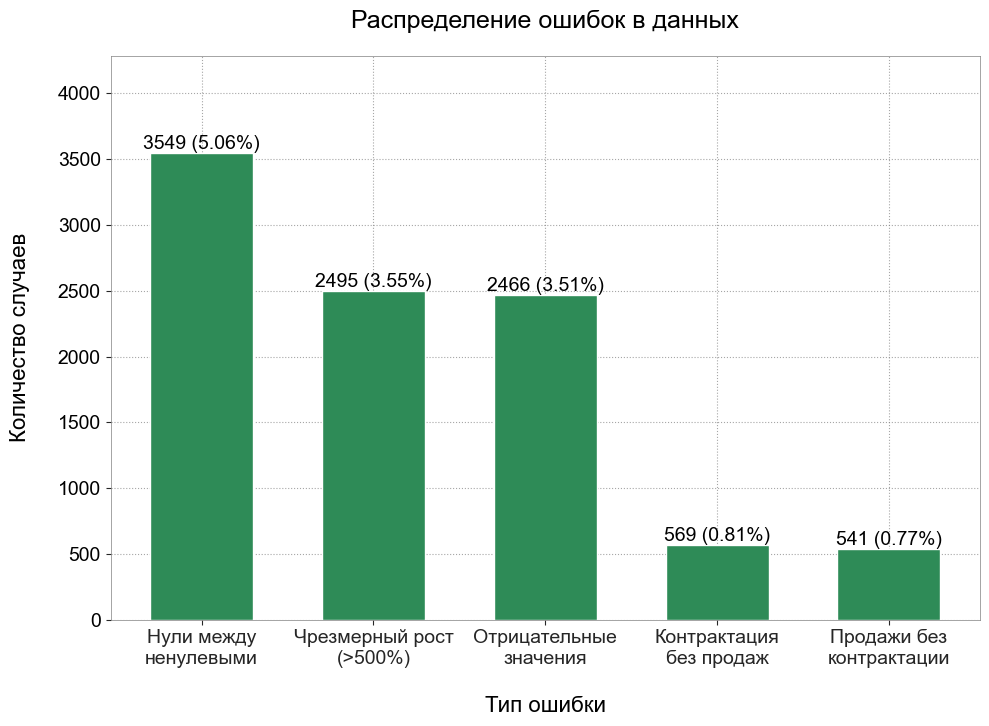

In [11]:
# Применяем функцию визуализации
error_viz_df = visualize_errors(error_df)

### 3.2 Построение графика распределения цен

#### 3.2.1 Функция графика

In [12]:
grouped = pd.read_csv(dcsv_directory + 'df_grouped.csv')
grouped.head()

,project,year,months,developer,region,okrug,corpus,ID,price,sales_live
0,31-й квартал (Пушкино),2019,7,Профи Инвест,Московская область,Ярославское шоссе,"очередь 2 корпус 1,очередь 2 корпус 2,очередь ...",1281,62062.0,9.454545
1,31-й квартал (Пушкино),2019,9,Профи Инвест,Московская область,Ярославское шоссе,"очередь 2 корпус 1,очередь 2 корпус 2,очередь ...",1281,62062.0,8.863636
2,31-й квартал (Пушкино),2019,10,Профи Инвест,Московская область,Ярославское шоссе,"очередь 2 корпус 1,очередь 2 корпус 2,очередь ...",1281,62062.0,9.159091
3,31-й квартал (Пушкино),2019,11,Профи Инвест,Московская область,Ярославское шоссе,"очередь 2 корпус 1,очередь 2 корпус 2,очередь ...",1281,62062.0,8.863636
4,31-й квартал (Пушкино),2019,12,Профи Инвест,Московская область,Ярославское шоссе,"очередь 2 корпус 1,очередь 2 корпус 2,очередь ...",1281,62062.0,2.659091


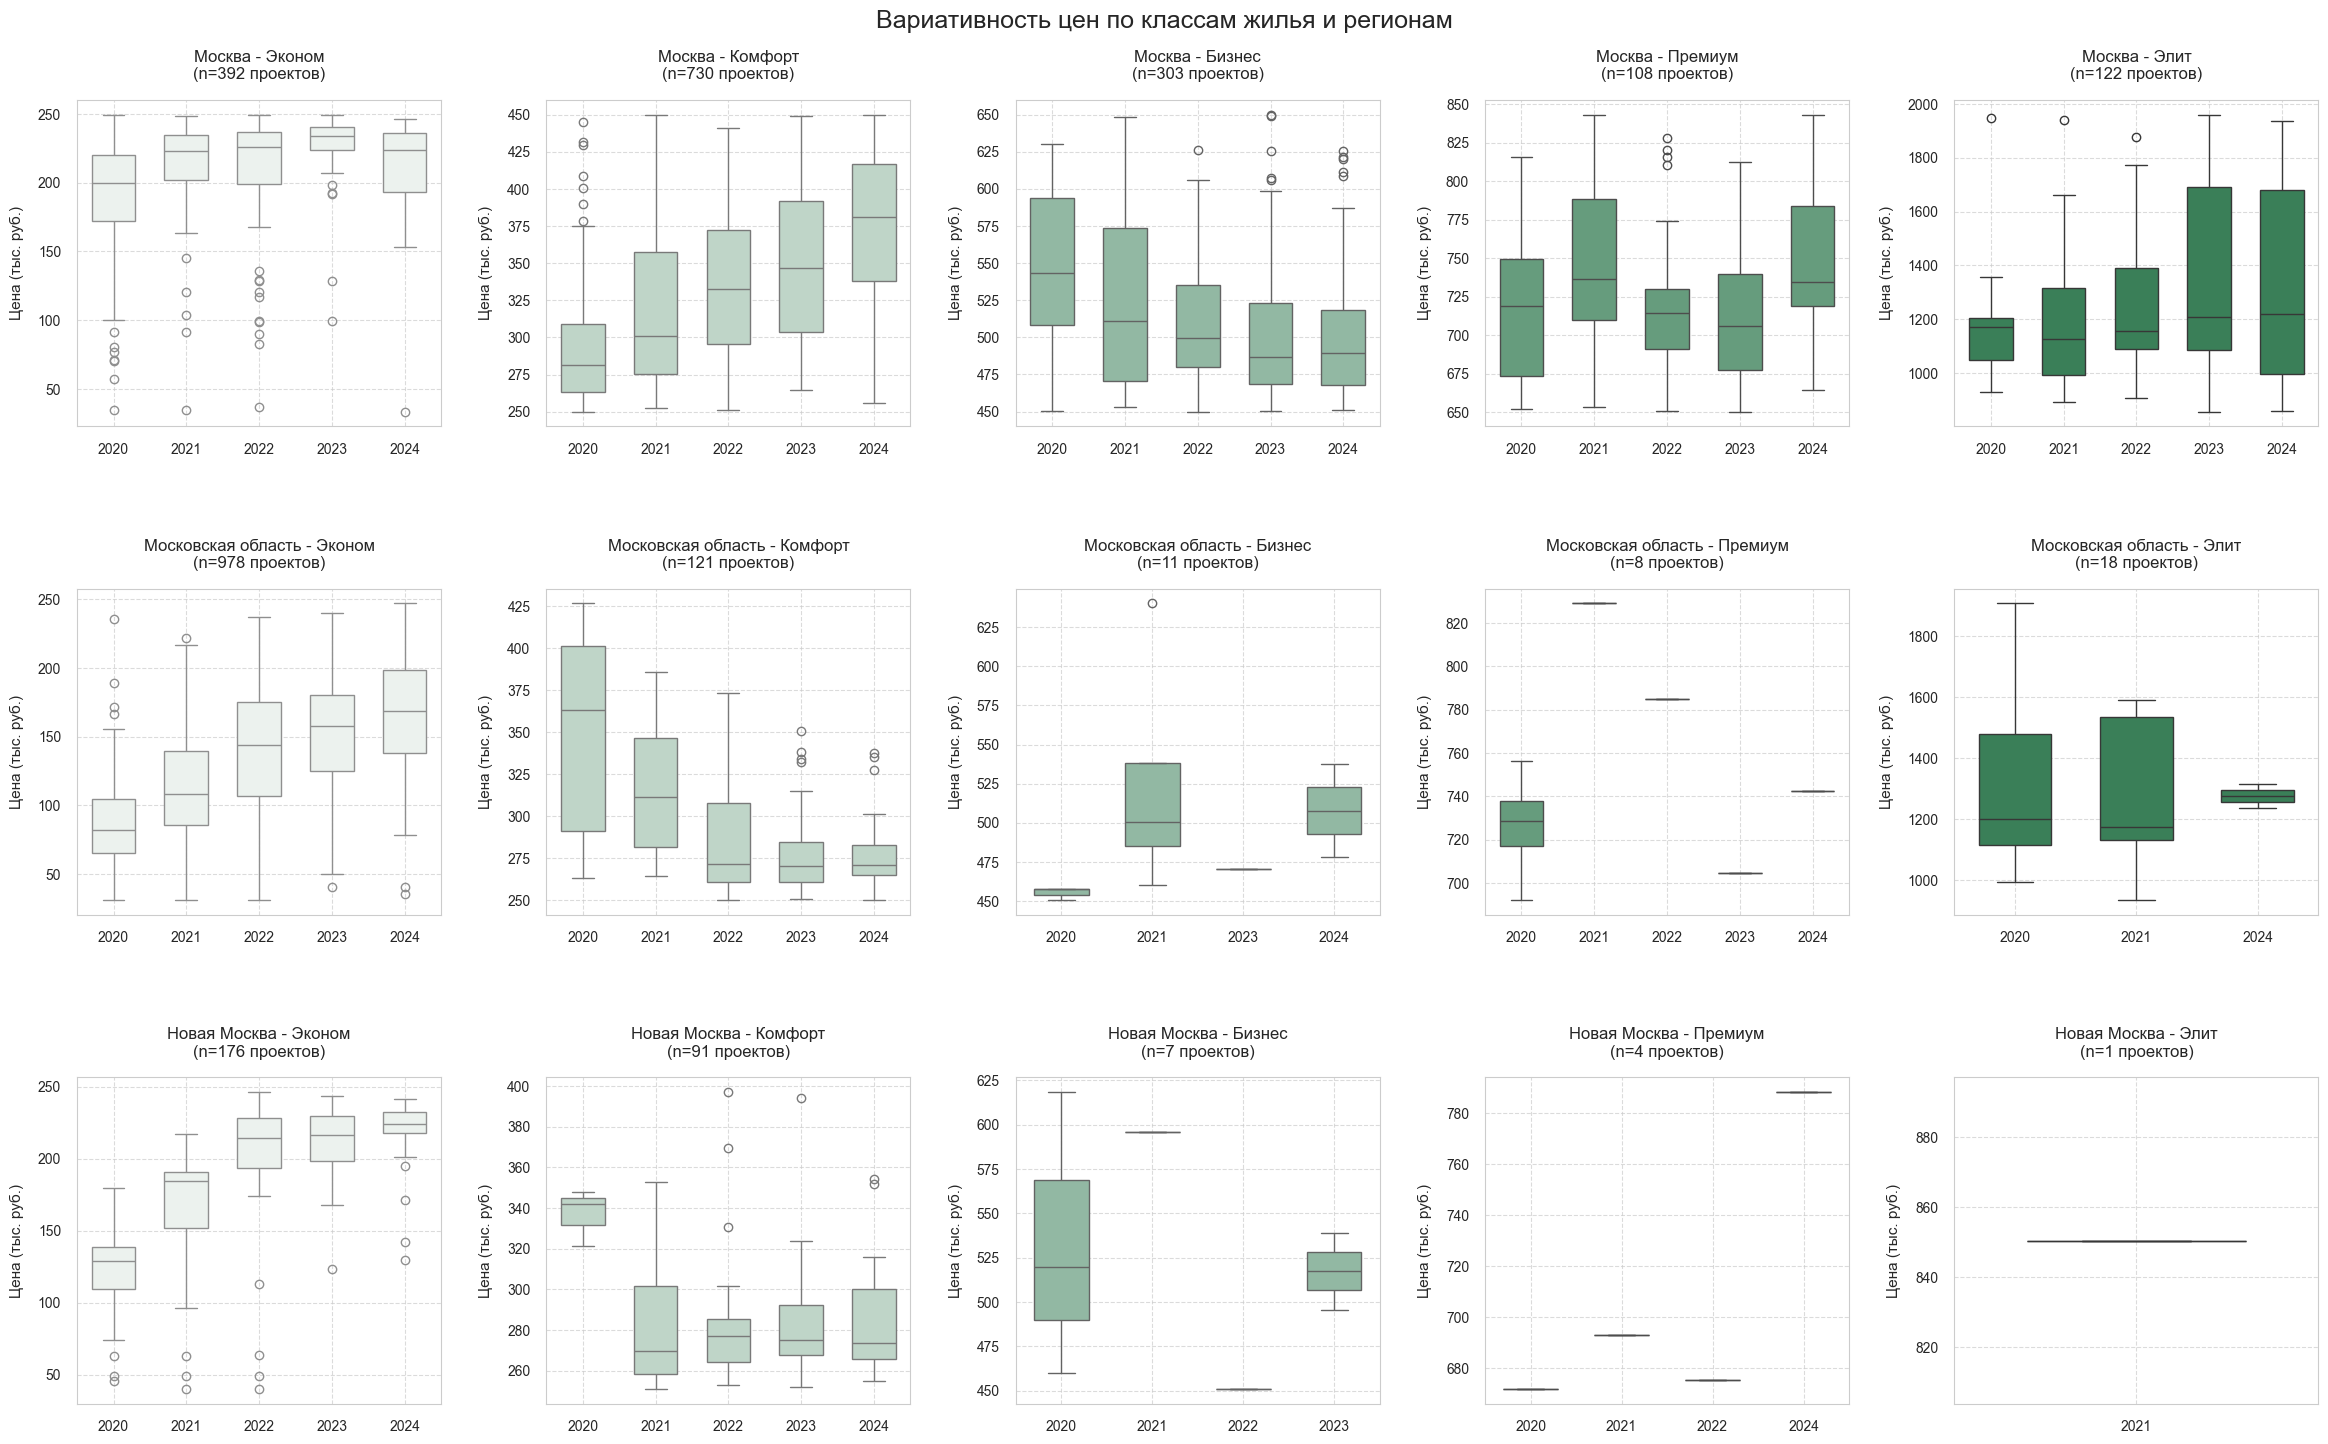

In [ ]:
import matplotlib.ticker as ticker


def classify_price(price):
    
    if price < 250000:
        return 'Эконом'
    elif price < 450000:
        return 'Комфорт'
    elif price < 650000:
        return 'Бизнес'
    elif price < 850000:
        return 'Премиум'
    else:
        return 'Элит'

# Применяем функцию классификации и фильтрацию
grouped['class'] = grouped['price'].apply(classify_price)
grouped = grouped[grouped['price'] > 30000]
grouped['date'] = pd.to_datetime(grouped['year'].astype(str) + '-' + grouped['months'].astype(str) + '-01')

# Агрегируем данные: для каждого проекта берем среднюю цену за год
df_agg = grouped.groupby(['project', 'region', 'year', 'class'])['price'].mean().reset_index()

# Константы
REGIONS = ['Москва', 'Московская область', 'Новая Москва']
CLASS_ORDER = ['Эконом', 'Комфорт', 'Бизнес', 'Премиум', 'Элит']

# Настройка стиля графиков
sns.set_style("whitegrid")
plt.rcParams.update({
                    'font.size': 11,
                    'axes.titlesize': 12,
                    'axes.labelsize': 11,
                    'xtick.labelsize': 10,
                    'ytick.labelsize': 10
                    })

# Создаем цветовую палитру
green_palette = sns.light_palette("seagreen", n_colors=len(CLASS_ORDER), reverse=False)

# Создаем сетку графиков
fig, axes = plt.subplots(len(REGIONS), len(CLASS_ORDER), figsize=(24, 15), sharey=False)
fig.suptitle('Вариативность цен по классам жилья и регионам', fontsize=18, y=0.98)

# Заполняем графики
for i, region in enumerate(REGIONS):
    for j, housing_class in enumerate(CLASS_ORDER):
        ax = axes[i, j]
        
        # Фильтруем данные для текущего региона и класса жилья
        subset = df_agg[(df_agg['region'] == region) & (df_agg['class'] == housing_class)]
        
        if not subset.empty:
            
            # Строим боксплот с исправленным использованием цвета
            sns.boxplot(
                        x='year', 
                        y='price', 
                        data=subset, 
                        ax=ax,
                        color=green_palette[j],  # <-- используем color вместо palette
                        width=0.6
                        )
            
            # Правильное форматирование меток оси Y
            formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}')
            ax.yaxis.set_major_formatter(formatter)
            
            # Настраиваем внешний вид
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_xlabel('', labelpad=10)
            ax.set_ylabel('Цена (тыс. руб.)', labelpad=10)
            
            # Добавляем информацию о количестве проектов
            total_count = len(subset)
            ax.set_title(f'{region} - {housing_class}\n(n={total_count} проектов)', pad=15)
            
            # Настройка отступов
            ax.tick_params(axis='x', pad=8)
            ax.tick_params(axis='y', pad=8)
            
        else:
            ax.text(0.5, 0.5, 'Нет данных', 
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax.transAxes)
            ax.set_title(f'{region} - {housing_class}')


# Настраиваем общий макет
plt.tight_layout(pad=3.0, h_pad=5.0, w_pad=2.0)
plt.subplots_adjust(top=0.92)

### 3.3 График динамики количества проектов

#### 3.3.1 Функция построения графика 

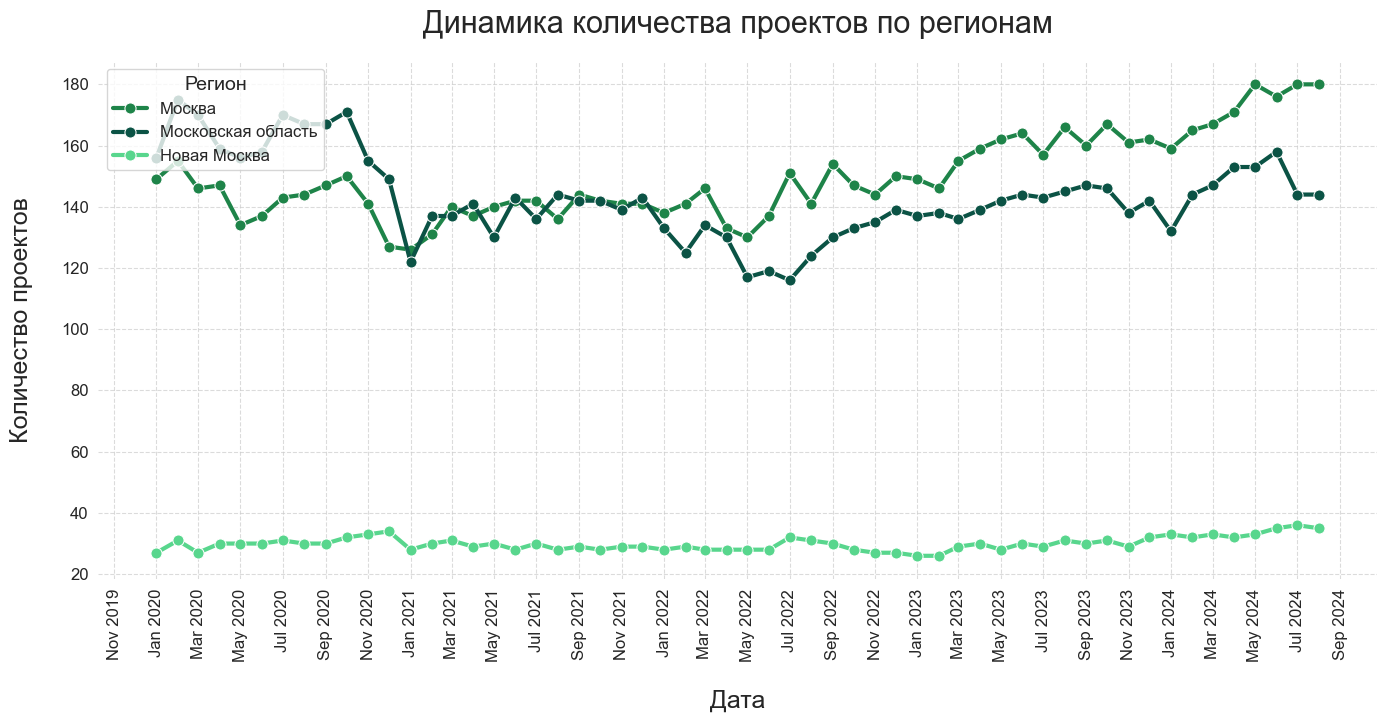

In [14]:
import matplotlib.dates as mdates


# Создаем столбец даты из yearа и месяца
grouped['Дата'] = pd.to_datetime(grouped['year'].astype(str) + '-' + grouped['months'].astype(str) + '-01')
grouped = grouped[grouped['Дата'].isin(pd.date_range('2020-01-01', '2024-08-31'))]

# Группируем данные по месяцу и regionу, считаем уникальные проекты
monthly_counts = grouped.groupby(['Дата', 'region'])['project'].nunique().reset_index()
monthly_counts.rename(columns={'project': 'Количество проектов'}, inplace=True)

# Настраиваем стиль графика
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Создаем палитру зеленых оттенков
green_palette = ['#1E8449', '#0B5345', '#58D68D']

# Строим линейный график
ax = sns.lineplot(
                data=monthly_counts,
                x='Дата',
                y='Количество проектов',
                hue='region',
                palette=green_palette,
                linewidth=3,
                marker='o',
                markersize=8
                )

# Настраиваем форматирование дат на оси X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Добавляем заголовок и подписи осей с увеличенным размером и отступом
plt.title('Динамика количества проектов по регионам', fontsize=22, pad=20)
plt.xlabel('Дата', fontsize=18, labelpad=20)
plt.ylabel('Количество проектов', fontsize=18, labelpad=20)

# Настраиваем легенду
plt.legend(title='Регион', title_fontsize=14, fontsize=12, loc='upper left', frameon=True)

# Добавляем сетку для лучшей читаемости
plt.grid(True, linestyle='--', alpha=0.7)

# Улучшаем внешний вид
sns.despine(left=True, bottom=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # <-- оставляем место для надписей
plt.show()